In [1]:
import glob
from astropy.io import fits
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from ginga.util import zscale
from astropy.time import Time

In [2]:
def find_anom_pixels(epoch_mean_flat, ideal_median_flat, threshold, mask_DQ = False, 
                     mask_border = True,plotting = True):
    ##############################################
    ##          get data from fits files        ##
    ##############################################
    hdu_epoch = fits.open(epoch_mean_flat)
    sci_1_epoch = hdu_epoch['SCI',1].data
    sci_2_epoch = hdu_epoch['SCI',2].data
    if mask_DQ:
        dq_1_epoch = hdu_epoch['DQ',1].data
        dq_2_epoch = hdu_epoch['DQ',2].data  
    hdu_median = fits.open(ideal_median_flat)
    sci_1_median = hdu_median['SCI',1].data
    sci_2_median = hdu_median['SCI',2].data
    if mask_DQ:
        dq_1_median = hdu_median['DQ',1].data
        dq_2_median = hdu_median['DQ',2].data 
    ##############################################
    ##mask top and bottom 10 pixels in each chip##
    ##############################################
    if mask_border:
        sci_1_epoch[0:10], sci_1_epoch[-10:] = np.nan, np.nan
        sci_2_epoch[0:10], sci_2_epoch[-10:] = np.nan, np.nan
        sci_1_median[0:10], sci_1_median[-10:] = np.nan, np.nan
        sci_2_median[0:10], sci_2_median[-10:] = np.nan, np.nan
        if mask_DQ:
            dq_1_epoch[0:10], dq_1_epoch[-10:] = np.nan, np.nan
            dq_2_epoch[0:10], dq_2_epoch[-10:] = np.nan, np.nan
            dq_1_median[0:10], dq_1_median[-10:] = np.nan, np.nan
            dq_2_median[0:10], dq_2_median[-10:] = np.nan, np.nan
    ##############################################
    ##  mask all pixels flagged with a DQ flag  ##
    ##############################################
    if mask_DQ:
        sci_1_epoch[dq_1_epoch != 0] = np.nan
        sci_2_epoch[dq_2_epoch != 0] = np.nan
        sci_1_median[dq_1_median != 0] = np.nan
        sci_2_epoch[dq_2_epoch != 0] = np.nan
    ##############################################
    ##    subtracting and dividing the median   ##
    ##############################################
    dif_sci_1 = ((sci_1_epoch-sci_1_median)/sci_1_median)*100
    dif_sci_2 = ((sci_2_epoch-sci_2_median)/sci_2_median)*100
    
    counter = 0
    for i in dif_sci_1:
        for val in i:
            if val < threshold:
                if val > -10.:
                    counter += 1
                
    a = epoch_mean_flat.split('/')[-1]
    a = a.replace('.fits','')
    a = a.split('_')
    anneal_date = a[-2]
    date_obs = a[-1]
    #print counter,'low sensitivity pixels found',anneal_date,date_obs
    #print counter
    return (counter,date_obs,anneal_date)
    

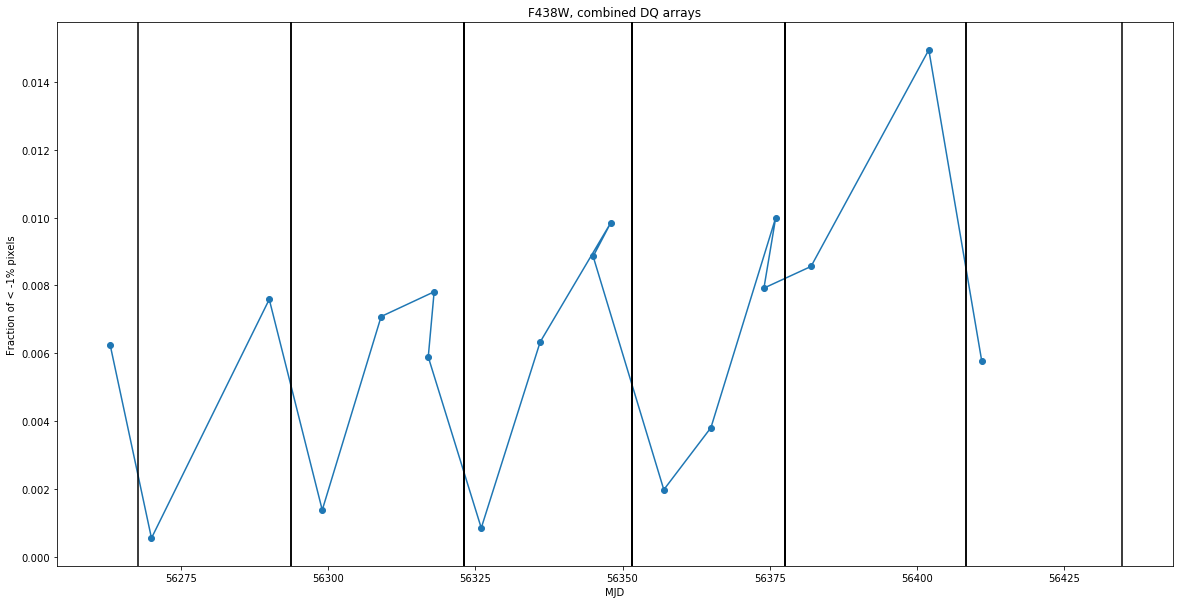

In [25]:
#F438W
#'combined dq' files are flats for which a master DQ array was made for all combined images 

epoch_flats_combined_dq = glob.glob('/grp/hst/wfc3t/cshanahan/QE_pixel_monitor_repeat/data/F438W/*/*/*mean*')
median_flat_combined_dq = glob.glob('/grp/hst/wfc3t/cshanahan/QE_pixel_monitor_repeat/data/F438W/*individual*')

nums = []
visit_dates = []
anneal_dates = []
for i, epoch_flat in enumerate(epoch_flats_combined_dq):
    counter,date_obs,anneal_date = find_anom_pixels(epoch_flat, median_flat_combined_dq[0], threshold=-1.0,mask_DQ = True, mask_border = True)
    #print vals[0]
    #print 'file',i,'of',len(epoch_flats_combined_dq)
    nums.append(counter)
    visit_dates.append(date_obs)
    anneal_dates.append(anneal_date)

t = Time(visit_dates, format='isot')
visit_dates = t.mjd
anneal_dates = [float(item) for item in anneal_dates]
nums = [item / (2051.*4096) for item in nums]
#print nums
#print visit_dates
#print anneal_dates
fig = plt.figure(figsize=(20,10))
plt.title('F438W, combined DQ arrays')
plt.plot(visit_dates,nums)
plt.scatter(visit_dates,nums)
plt.xlabel('MJD')
plt.ylabel('Fraction of < -1% pixels')
for dat in anneal_dates:
    plt.axvline(dat,c='k')
